In [1]:
import re

import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from sklearn.svm import SVC

columns = ["ProductName", "level_1", "level_2", "level_3", "PricePerItem", "PriceMode", "HasMultiBuyDeal",
           "MultiBuyDeal", "MultiBuyBasePrice", "MultiBuyPrice", "MultiBuyQuantity", "PromoBadgeImageLabel"]
df = pd.read_csv("data.csv", usecols=columns)
df.drop_duplicates(inplace=True)
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,Johnson's Baby Lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
1,Johnson's Baby Oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
2,SMA Balanced Nutrition From Birth Infant Formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,NaN,17.99,17.99,1.0,Saver
3,Johnson's Baby Powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,NaN,2.99,2.99,1.0,Saver
4,Johnson's Baby Powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,NaN,4.89,NaN,NaN,NaN


In [3]:
punctuations = re.compile(r'[^a-zA-Z\s]+')
df["ProductName"] = [" ".join(punctuations.sub('', x).lower().split()) for x in df["ProductName"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,NaN,17.99,17.99,1.0,Saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,NaN,2.99,2.99,1.0,Saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,NaN,4.89,NaN,NaN,NaN


In [4]:
df["MultiBuyDeal"] = [" ".join(punctuations.sub('', y).lower().split()) if y == y else " " for y in
                      df["MultiBuyDeal"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,NaN
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,NaN
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,Saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,Saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,NaN,NaN,NaN


In [5]:
df["PromoBadgeImageLabel"] = [" ".join(punctuations.sub('', z).lower().split()) if z == z else " " for z in
                              df["PromoBadgeImageLabel"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,NaN,NaN,


In [6]:
df["MultiBuyPrice"].fillna(0, inplace=True)
df["MultiBuyQuantity"].fillna(0, inplace=True)
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,0.00,0.0,


<BarContainer object of 449 artists>

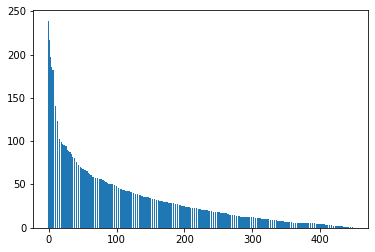

In [7]:
typesa = df.value_counts(columns[1:4])
plot.bar([a for a in range(typesa.size)], typesa)

<BarContainer object of 43 artists>

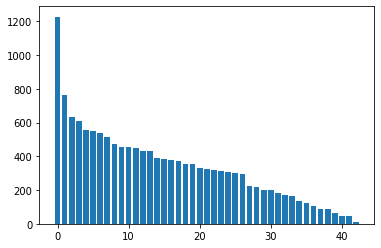

In [8]:
typesb = df.value_counts(columns[1:3])
plot.bar([a for a in range(typesb.size)], typesb)

In [9]:
typesc = df.value_counts(columns[1:2])
typesc

level_1                    
Pantry                         4740
Personal Care                  1778
Fresh Foods & Bakery           1721
Chilled, Frozen & Desserts     1426
Beer, Cider & Wine             1232
Kitchen, Dining & Household    1182
Drinks                         1063
Pets                            512
Meal Spot                       456
Baby, Toddler & Kids            354
Featured                        121
dtype: int64

In [10]:
df = df[df["level_1"] != "Featured"]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,0.00,0.0,


(array([1.974e+03, 4.555e+03, 3.223e+03, 1.367e+03, 9.790e+02, 5.380e+02,
        5.470e+02, 1.890e+02, 2.290e+02, 1.670e+02, 1.250e+02, 7.600e+01,
        2.800e+01, 2.000e+01, 2.800e+01, 1.200e+01, 2.200e+01, 6.000e+00,
        1.200e+01, 1.000e+00, 1.200e+01, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.15  ,   2.5668,   4.9836,   7.4004,   9.8172,  12.234 ,
         14.6508,  17.0676,  19.4844,  21.9012,  24.318 ,  26.7348,
         29.1516,  31.5684,  33.9852,  36.402 ,  38.8188,  41.2356,
         43.6524,  46.0692,  48.486 ,  50.9028,  53.3196,  55.7364,
         58.1532,  60.57  ,  62.9868,  65.4036,  67.8204,  70.2372,
         72.654 ,  75.0708,  77.4876

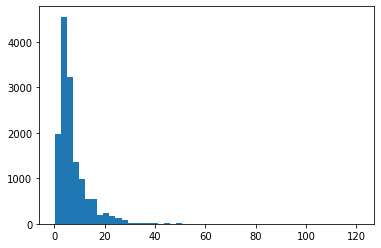

In [11]:
dfea = df[df["PriceMode"] == "ea"]
plot.hist(dfea["PricePerItem"].tolist(), bins=50)

(array([13., 21., 25., 13., 22., 30., 33.,  9., 41., 19., 45., 11.,  9.,
        14.,  9.,  1.,  3.,  3.,  7.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  2.29  ,   4.8422,   7.3944,   9.9466,  12.4988,  15.051 ,
         17.6032,  20.1554,  22.7076,  25.2598,  27.812 ,  30.3642,
         32.9164,  35.4686,  38.0208,  40.573 ,  43.1252,  45.6774,
         48.2296,  50.7818,  53.334 ,  55.8862,  58.4384,  60.9906,
         63.5428,  66.095 ,  68.6472,  71.1994,  73.7516,  76.3038,
         78.856 ,  81.4082,  83.9604,  86.5126,  89.0648,  91.617 ,
         94.1692,  96.7214,  99.2736, 101.8258, 104.378 , 106.9302,
        109.4824, 112.0346, 114.5868, 117.139 , 119.6912, 122.2434,
        124.7956, 127.3478, 129.9   ]),
 <BarContainer object of 50 artists>)

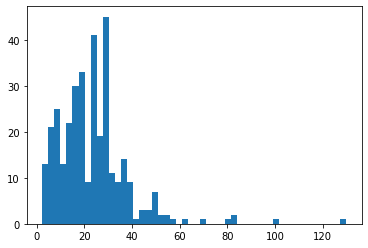

In [12]:
dfkg = df[df["PriceMode"] == "kg"]
plot.hist(dfkg["PricePerItem"].tolist(), bins=50)

In [13]:
df["PricePerItem"] = [round(p / 5) * 5 for p in df["PricePerItem"].tolist()]
df["MultiBuyPrice"] = [round(p / 5) * 5 for p in df["MultiBuyPrice"].tolist()]
df["MultiBuyBasePrice"] = [round(p / 5) * 5 for p in df["MultiBuyBasePrice"].tolist()]
df["MultiBuyQuantity"] = [int(q) for q in df["MultiBuyQuantity"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,5,ea,False,,5,0,0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,5,ea,False,,5,0,0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,20,ea,False,,20,20,1,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,5,ea,False,,5,5,1,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,5,ea,False,,5,0,0,


In [14]:
levela = df["level_1"].tolist()
levelb = df["level_2"].tolist()
two = [";".join([levela[i], levelb[i]]) for i in range(len(levela))]
one = levela

In [15]:
texts = df["ProductName"].tolist()
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(texts)

In [16]:
label2idtwo = {l: i for i, l in enumerate(set(two))}
id2labeltwo = {i: l for l, i in label2idtwo.items()}
two = [label2idtwo[l] for l in two]
label2idone = {l: i for i, l in enumerate(set(one))}
id2labelone = {i: l for l, i in label2idone.items()}
one = [label2idone[l] for l in one]
x_traint, x_testt, y_traint, y_testt = train_test_split(features, two, test_size=0.25, random_state=3)
x_traino, x_testo, y_traino, y_testo = train_test_split(features, one, test_size=0.25, random_state=3)

In [17]:
model = LogisticRegression(max_iter=500)
model.fit(x_traint, y_traint)
predict_labelst = model.predict(x_testt)
predict_labelst = [np.round(p) for p in predict_labelst]
max_labelt = len(id2labeltwo) - 1
predict_labelst = [l if max_labelt >= l else max_labelt for l in predict_labelst]
min_label = 0
predict_labelst = [l if min_label <= l else min_label for l in predict_labelst]
print(classification_report(y_testt, predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                       Personal Care;Health & Wellness       0.88      0.87      0.87       123
                       Beer, Cider & Wine;Beer & Cider       0.96      0.94      0.95       130
                         Fresh Foods & Bakery;Butchery       0.98      0.77      0.86        53
                 Kitchen, Dining & Household;Household       0.87      0.97      0.92       140
                          Pantry;Pasta, Rice & Noodles       0.66      0.62      0.64        82
Kitchen, Dining & Household;Stationery & Entertainment       1.00      0.68      0.81        25
                                  Pantry;Confectionery       0.89      0.95      0.92       104
                           Pantry;Salad & Cooking Oils       0.94      0.88      0.91        33
                   Kitchen, Dining & Household;Laundry       1.00      0.77      0.87        44
                     Fresh Foods & Bake

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model = LogisticRegression(max_iter=500)
model.fit(x_traino, y_traino)
predict_labelso = model.predict(x_testo)
predict_labelso = [np.round(p) for p in predict_labelso]
max_labelo = len(id2labelone) - 1
predict_labelso = [l if max_labelo >= l else max_labelo for l in predict_labelso]
min_label = 0
predict_labelso = [l if min_label <= l else min_label for l in predict_labelso]
print(classification_report(y_testo, predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))

                             precision    recall  f1-score   support

                       Pets       1.00      0.94      0.97       126
       Baby, Toddler & Kids       1.00      0.82      0.90        93
       Fresh Foods & Bakery       0.74      0.67      0.70       436
                  Meal Spot       0.24      0.13      0.17       110
Kitchen, Dining & Household       0.98      0.88      0.93       288
              Personal Care       0.95      0.94      0.95       411
         Beer, Cider & Wine       0.99      0.92      0.95       301
                     Drinks       0.70      0.63      0.66       249
 Chilled, Frozen & Desserts       0.66      0.59      0.62       366
                     Pantry       0.77      0.92      0.84      1236

                   accuracy                           0.81      3616
                  macro avg       0.80      0.74      0.77      3616
               weighted avg       0.80      0.81      0.80      3616



In [19]:
k = len(id2labeltwo)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_traint, y_traint)
predict_labelst = model.predict(x_testt)
print(classification_report(y_testt, predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                       Personal Care;Health & Wellness       0.87      0.76      0.81       123
                       Beer, Cider & Wine;Beer & Cider       0.94      0.89      0.92       130
                         Fresh Foods & Bakery;Butchery       0.84      0.77      0.80        53
                 Kitchen, Dining & Household;Household       0.86      0.76      0.81       140
                          Pantry;Pasta, Rice & Noodles       0.66      0.73      0.69        82
Kitchen, Dining & Household;Stationery & Entertainment       0.89      0.64      0.74        25
                                  Pantry;Confectionery       0.77      0.93      0.84       104
                           Pantry;Salad & Cooking Oils       0.68      0.85      0.76        33
                   Kitchen, Dining & Household;Laundry       0.84      0.82      0.83        44
                     Fresh Foods & Bake

In [20]:
k = len(id2labelone)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_traino, y_traino)
predict_labelso = model.predict(x_testo)
print(classification_report(y_testo, predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))

                             precision    recall  f1-score   support

                       Pets       0.98      0.97      0.98       126
       Baby, Toddler & Kids       0.95      0.89      0.92        93
       Fresh Foods & Bakery       0.68      0.78      0.73       436
                  Meal Spot       0.31      0.33      0.32       110
Kitchen, Dining & Household       0.94      0.90      0.92       288
              Personal Care       0.95      0.93      0.94       411
         Beer, Cider & Wine       0.98      0.94      0.96       301
                     Drinks       0.65      0.82      0.73       249
 Chilled, Frozen & Desserts       0.69      0.61      0.64       366
                     Pantry       0.87      0.83      0.85      1236

                   accuracy                           0.82      3616
                  macro avg       0.80      0.80      0.80      3616
               weighted avg       0.83      0.82      0.82      3616



In [21]:
def knn_cross_validation(x_train, y_train):
    k_list = list(range(1, 30))
    list_scores = []

    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        list_scores.append(scores.mean())

    MSE = [1 - x for x in list_scores]
    optimal_k = k_list[MSE.index(min(MSE))]
    print("The optimal number of neighbors is %d" % optimal_k)
    plot.plot(k_list, list_scores)
    plot.xlabel('Number of Neighbors K')
    plot.ylabel('correct classification rate')
    plot.show()
    return optimal_k

The optimal number of neighbors is 6


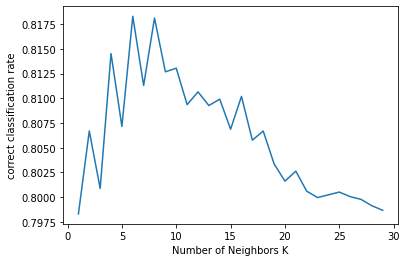

In [22]:
ko = knn_cross_validation(x_traino, y_traino)

The optimal number of neighbors is 4


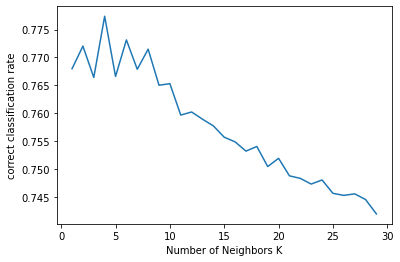

In [23]:
kt = knn_cross_validation(x_traint, y_traint)

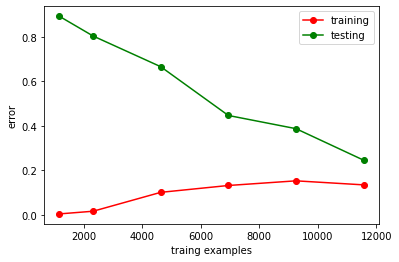

In [24]:
knn = KNeighborsClassifier(n_neighbors=kt)
train_sizes, train_score, test_score = learning_curve(knn, features, two, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

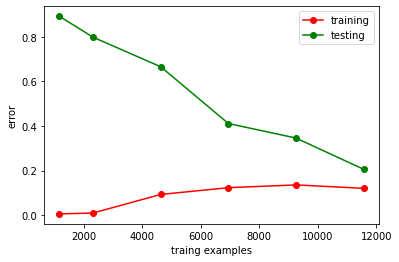

In [25]:
knn = KNeighborsClassifier(n_neighbors=ko)
train_sizes, train_score, test_score = learning_curve(knn, features, one, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

In [26]:
model = OneVsRestClassifier(SVC())
model.fit(x_traint, y_traint)
svm_predict_labelst = model.predict(x_testt)
print(
    classification_report(y_testt, svm_predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                       Personal Care;Health & Wellness       0.93      0.87      0.90       123
                       Beer, Cider & Wine;Beer & Cider       0.99      0.96      0.98       130
                         Fresh Foods & Bakery;Butchery       0.98      0.91      0.94        53
                 Kitchen, Dining & Household;Household       0.94      0.95      0.94       140
                          Pantry;Pasta, Rice & Noodles       0.68      0.70      0.69        82
Kitchen, Dining & Household;Stationery & Entertainment       1.00      0.88      0.94        25
                                  Pantry;Confectionery       0.96      1.00      0.98       104
                           Pantry;Salad & Cooking Oils       0.88      0.91      0.90        33
                   Kitchen, Dining & Household;Laundry       0.96      0.98      0.97        44
                     Fresh Foods & Bake

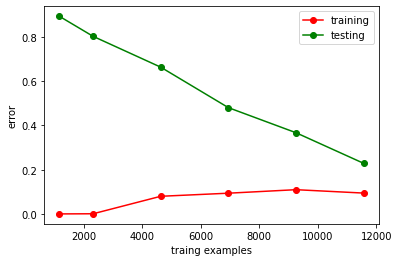

In [27]:
train_sizes, train_score, test_score = learning_curve(SVC(), features, two, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

In [28]:
model = OneVsRestClassifier(SVC())
model.fit(x_traino, y_traino)
svm_predict_labelso = model.predict(x_testo)
print(
    classification_report(y_testo, svm_predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))

                             precision    recall  f1-score   support

                       Pets       1.00      1.00      1.00       126
       Baby, Toddler & Kids       1.00      0.90      0.95        93
       Fresh Foods & Bakery       0.73      0.66      0.69       436
                  Meal Spot       0.05      0.04      0.04       110
Kitchen, Dining & Household       0.97      0.95      0.96       288
              Personal Care       0.96      0.96      0.96       411
         Beer, Cider & Wine       1.00      0.96      0.98       301
                     Drinks       0.64      0.66      0.65       249
 Chilled, Frozen & Desserts       0.64      0.63      0.64       366
                     Pantry       0.82      0.88      0.85      1236

                   accuracy                           0.82      3616
                  macro avg       0.78      0.77      0.77      3616
               weighted avg       0.81      0.82      0.81      3616



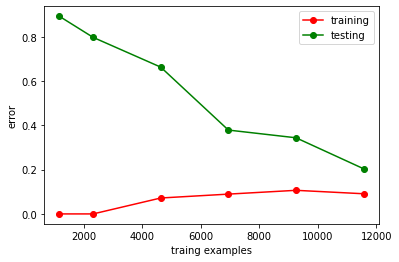

In [29]:
train_sizes, train_score, test_score = learning_curve(SVC(), features, one, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

In [30]:
# def load_embeddings():
#     cache = '.vector_cache'
#     if not os.path.exists(cache):
#         os.mkdir(cache)
#     word2vec = vocab.Vectors(name=r'./word2vec_300dim.txt', cache=cache)
#     return word2vec
#
#
# def encode_text_to_features(vector, text):
#     vectors = vector.get_vecs_by_tokens(text.split())
#     sentence_vector = torch.mean(vectors, dim=0)
#     return sentence_vector.tolist()
#
# sentences = []
# map(remove_stopwords,texts)
# for sentence in texts:
#     sentences.append(sentence.split())
# w2v = Word2Vec(sentences=sentences, vector_size=300, window=1, min_count=1)
# w2v.wv.save_word2vec_format(r'./word2vec_300dim.txt', binary=False)
# vector = load_embeddings()
# features = [encode_text_to_features(vector, text) for text in texts]
#

In [31]:
# x_traint, x_testt, y_traint, y_testt = train_test_split(features, two, test_size=0.25, random_state=3)
# x_traino, x_testo, y_traino, y_testo = train_test_split(features, one, test_size=0.25, random_state=3)

In [32]:
# model = LogisticRegression(max_iter=500)
# model.fit(x_traint, y_traint)
# predict_labelst = model.predict(x_testt)
# predict_labelst = [np.round(p) for p in predict_labelst]
# max_labelt = len(id2labeltwo) - 1
# predict_labelst = [l if max_labelt >= l else max_labelt for l in predict_labelst]
# min_label = 0
# predict_labelst = [l if min_label <= l else min_label for l in predict_labelst]
# print(classification_report(y_testt, predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

In [33]:
# model = LogisticRegression(max_iter=500)
# model.fit(x_traino, y_traino)
# predict_labelso = model.predict(x_testo)
# predict_labelso = [np.round(p) for p in predict_labelso]
# max_labelo = len(id2labelone) - 1
# predict_labelso = [l if max_labelo >= l else max_labelo for l in predict_labelso]
# min_label = 0
# predict_labelst = [l if min_label <= l else min_label for l in predict_labelso]
# print(classification_report(y_testo, predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))
